Models used for the binary classification problem includes:  
* LogisticRegression (best model)
* kNearestNeighbor
* BaggingClassifier
* RandomForestClassifier
* XGBoost
* AdaBoostClassifier
* VotingClassifier  

The best model was found to be LogReg with a train/validation `area_under_curve` AUC score of around 0.81 and a test AUC score of 0.70. More pertinently, its Recall rate ("true positive rate") was found to be high at 0.78. Given an extremely imbalanced dataset where positive cases only constitues 5% of the entire dataset, being able to predict 78% of this small minority correctly is a feat.  

All the selected features are leading indicators comprising of time-lagged features and two clustered features, `NumMosquitos_cluster` and `trap_cluster` which can be encoded beforehand with sufficient past data. This allows our best model to be not just predictive, but also highly anticipatory. 

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
# from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# from sklearn.feature_selection import mutual_info_regression
# from math import sqrt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

from sklearn.decomposition import PCA

%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)

import seaborn as sns

In [2]:
test_file = './datasets/cleaned_test.csv'
train_file = './datasets/cleaned_train.csv'
spray_file = './datasets/spray.csv'
weather_file = './datasets/station_1_weather.csv'


train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
spray_df = pd.read_csv(spray_file)
weather_df = pd.read_csv(weather_file)

In [3]:
# Convert all Dates to DatetimeIndex first for merging by dates
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)

train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

In [4]:
# Merge train_df  and weather_df
train_weather = train_df.merge(weather_df, on='Date')
test_weather = test_df.merge(weather_df, on='Date')

In [5]:
# Classify weather conditions from 3 weeks ago 
train_weather['superHot_Dry_lag_3'] = np.where((train_weather['weekly_Tavg_lag_3']>=70) & (train_weather['weekly_rh_lag_3']<60), 1, 0)
train_weather['superHot_Wet_lag_3'] = np.where((train_weather['weekly_Tavg_lag_3']>=70) & (train_weather['weekly_rh_lag_3']>=60), 1, 0)
train_weather['Hot_Dry_lag_3'] = np.where((train_weather['weekly_Tavg_lag_3']>65) & (train_weather['weekly_Tavg_lag_3']<70) & (train_weather['weekly_rh_lag_3']<60), 1, 0)
train_weather['Hot_Wet_lag_3'] = np.where((train_weather['weekly_Tavg_lag_3']>65) & (train_weather['weekly_Tavg_lag_3']<70) & (train_weather['weekly_rh_lag_3']>=60), 1, 0)
train_weather['Cool_Dry_lag_3'] = np.where((train_weather['weekly_Tavg_lag_3']<=65) & (train_weather['weekly_rh_lag_3']<60), 1, 0)
train_weather['Cool_Wet_lag_3'] = np.where((train_weather['weekly_Tavg_lag_3']<=65) & (train_weather['weekly_rh_lag_3']>=60), 1, 0)


# Do the same for test set
test_weather['superHot_Dry_lag_3'] = np.where((test_weather['weekly_Tavg_lag_3']>=70) & (test_weather['weekly_rh_lag_3']<60), 1, 0)
test_weather['superHot_Wet_lag_3'] = np.where((test_weather['weekly_Tavg_lag_3']>=70) & (test_weather['weekly_rh_lag_3']>=60), 1, 0)
test_weather['Hot_Dry_lag_3'] = np.where((test_weather['weekly_Tavg_lag_3']>65) & (test_weather['weekly_Tavg_lag_3']<70) & (test_weather['weekly_rh_lag_3']<60), 1, 0)
test_weather['Hot_Wet_lag_3'] = np.where((test_weather['weekly_Tavg_lag_3']>65) & (test_weather['weekly_Tavg_lag_3']<70) & (test_weather['weekly_rh_lag_3']>=60), 1, 0)
test_weather['Cool_Dry_lag_3'] = np.where((test_weather['weekly_Tavg_lag_3']<=65) & (test_weather['weekly_rh_lag_3']<60), 1, 0)
test_weather['Cool_Wet_lag_3'] = np.where((test_weather['weekly_Tavg_lag_3']<=65) & (test_weather['weekly_rh_lag_3']>=60), 1, 0)



In [6]:
# Classify weather conditions from 2 weeks ago 
train_weather['superHot_Dry_lag_2'] = np.where((train_weather['weekly_Tavg_lag_2']>=70) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
train_weather['superHot_Wet_lag_2'] = np.where((train_weather['weekly_Tavg_lag_2']>=70) & (train_weather['weekly_rh_lag_2']>=60), 1, 0)
train_weather['Hot_Dry_lag_2'] = np.where((train_weather['weekly_Tavg_lag_2']>65) & (train_weather['weekly_Tavg_lag_2']<70) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
train_weather['Hot_Wet_lag_2'] = np.where((train_weather['weekly_Tavg_lag_2']>65) & (train_weather['weekly_Tavg_lag_2']<70) & (train_weather['weekly_rh_lag_2']>=60), 1, 0)
train_weather['Cool_Dry_lag_2'] = np.where((train_weather['weekly_Tavg_lag_2']<=65) & (train_weather['weekly_rh_lag_2']<60), 1, 0)
train_weather['Cool_Wet_lag_2'] = np.where((train_weather['weekly_Tavg_lag_2']<=65) & (train_weather['weekly_rh_lag_2']>=60), 1, 0)


test_weather['superHot_Dry_lag_2'] = np.where((test_weather['weekly_Tavg_lag_2']>=70) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
test_weather['superHot_Wet_lag_2'] = np.where((test_weather['weekly_Tavg_lag_2']>=70) & (test_weather['weekly_rh_lag_2']>=60), 1, 0)
test_weather['Hot_Dry_lag_2'] = np.where((test_weather['weekly_Tavg_lag_2']>65) & (test_weather['weekly_Tavg_lag_2']<70) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
test_weather['Hot_Wet_lag_2'] = np.where((test_weather['weekly_Tavg_lag_2']>65) & (test_weather['weekly_Tavg_lag_2']<70) & (test_weather['weekly_rh_lag_2']>=60), 1, 0)
test_weather['Cool_Dry_lag_2'] = np.where((test_weather['weekly_Tavg_lag_2']<=65) & (test_weather['weekly_rh_lag_2']<60), 1, 0)
test_weather['Cool_Wet_lag_2'] = np.where((test_weather['weekly_Tavg_lag_2']<=65) & (test_weather['weekly_rh_lag_2']>=60), 1, 0)

In [7]:
# Classify weather conditions from 1 week ago 
train_weather['superHot_Dry_lag_1'] = np.where((train_weather['weekly_Tavg_lag_1']>=70) & (train_weather['weekly_rh_lag_1']<60), 1, 0)
train_weather['superHot_Wet_lag_1'] = np.where((train_weather['weekly_Tavg_lag_1']>=70) & (train_weather['weekly_rh_lag_1']>=60), 1, 0)
train_weather['Hot_Dry_lag_1'] = np.where((train_weather['weekly_Tavg_lag_1']>65) & (train_weather['weekly_Tavg_lag_1']<70) & (train_weather['weekly_rh_lag_1']<60), 1, 0)
train_weather['Hot_Wet_lag_1'] = np.where((train_weather['weekly_Tavg_lag_1']>65) & (train_weather['weekly_Tavg_lag_1']<70) & (train_weather['weekly_rh_lag_1']>=60), 1, 0)
train_weather['Cool_Dry_lag_1'] = np.where((train_weather['weekly_Tavg_lag_1']<=65) & (train_weather['weekly_rh_lag_1']<60), 1, 0)
train_weather['Cool_Wet_lag_1'] = np.where((train_weather['weekly_Tavg_lag_1']<=65) & (train_weather['weekly_rh_lag_1']>=60), 1, 0)


test_weather['superHot_Dry_lag_1'] = np.where((test_weather['weekly_Tavg_lag_1']>=70) & (test_weather['weekly_rh_lag_1']<60), 1, 0)
test_weather['superHot_Wet_lag_1'] = np.where((test_weather['weekly_Tavg_lag_1']>=70) & (test_weather['weekly_rh_lag_1']>=60), 1, 0)
test_weather['Hot_Dry_lag_1'] = np.where((test_weather['weekly_Tavg_lag_1']>65) & (test_weather['weekly_Tavg_lag_1']<70) & (test_weather['weekly_rh_lag_1']<60), 1, 0)
test_weather['Hot_Wet_lag_1'] = np.where((test_weather['weekly_Tavg_lag_1']>65) & (test_weather['weekly_Tavg_lag_1']<70) & (test_weather['weekly_rh_lag_1']>=60), 1, 0)
test_weather['Cool_Dry_lag_1'] = np.where((test_weather['weekly_Tavg_lag_1']<=65) & (test_weather['weekly_rh_lag_1']<60), 1, 0)
test_weather['Cool_Wet_lag_1'] = np.where((test_weather['weekly_Tavg_lag_1']<=65) & (test_weather['weekly_rh_lag_1']>=60), 1, 0)

In [8]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10413 entries, 2007-05-29 to 2013-09-26
Data columns (total 100 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Address                         10413 non-null  object 
 1   Species                         10413 non-null  object 
 2   Block                           10413 non-null  int64  
 3   Street                          10413 non-null  object 
 4   Trap                            10413 non-null  object 
 5   AddressNumberAndStreet          10413 non-null  object 
 6   Latitude                        10413 non-null  float64
 7   Longitude                       10413 non-null  float64
 8   AddressAccuracy                 10413 non-null  int64  
 9   NumMosquitos                    10413 non-null  int64  
 10  WnvPresent                      10413 non-null  int64  
 11  month_x                         10413 non-null  int64  
 12  year_x        

In [9]:
train_weather.columns

Index(['Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'month_x', 'year_x', 'week_x',
       'YearWeek_x', 'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'NumMosquitos_cluster', 'trap_cluster',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'month_y', 'year_y', 'week_y', 'YearWeek_y', 'rh', 'daily_Tavg_lag_1',
       'daily_Tavg_lag_2', 'daily_Tavg_lag_3', 'daily_Tavg_lag_4',
       'daily_Tavg_lag_5', 'daily_rh_lag_1', 'daily_rh_lag_2',
       'daily_rh_lag_3', 'daily_rh_lag_4', 'daily_rh_lag_5',
       'weekly_Tavg_lag_1', 'weekly_

In [11]:
# Export merged data for further analysis in More EDA on Train_Test_Sets

train_weather.to_csv('./datasets/train_weather.csv')

In [11]:
# Set of X features which produces kaggle score of 0.70-0.71 for LogReg 

# X_features = [
#             'Latitude', 
#             'Longitude',
#             'month_x',
        
#             'NumMosquitos_cluster', 
#             'trap_cluster', 

#             'daily_Tavg_lag_2', 

#             'daily_rh_lag_2', 

#             'daily_rh_lag_4', 

    
#             'weekly_Tavg_lag_1',
#             'weekly_Tavg_lag_2',
#             'weekly_Tavg_lag_3',

#             'weekly_precip_lag_3', 
#             'weekly_precip_lag_4',

#             'weekly_StnPressure_lag_2',
#             'weekly_StnPressure_lag_3', 
#             'weekly_StnPressure_lag_4',
    
#             'superHot_Dry_lag_3', 
#             'superHot_Wet_lag_3', 
#             'Hot_Dry_lag_3', 
#             'Hot_Wet_lag_3',
#             'Cool_Dry_lag_3', 
#             'Cool_Wet_lag_3',

#             'superHot_Dry_lag_1',



In [12]:
# Create new df for the selected X features for modeling

X_features = [
            'Latitude', 'Longitude',
            'month_x',             # duplicate 'month' column when merging train/test with weather
            #'Trap',
            #'AddressNumberAndStreet',
#             'Species_CULEX PIPIENS',
#             'Species_CULEX PIPIENS/RESTUANS',
#             'Species_CULEX RESTUANS',
#             'Species_CULEX SALINARIUS', 
#             'Species_CULEX TARSALIS',
#             'Species_CULEX TERRITANS',
#             'Species_CULEX ERRATICUS', 
            'NumMosquitos_cluster', 
            'trap_cluster', 
    
#             'WetBulb', 
#             'Heat', 
#             'Cool', 
#             'Sunrise', 
#             'Sunset',
#             'PrecipTotal', 
#             'StnPressure', 
#             'SeaLevel', 
#             'ResultSpeed', 
#             'ResultDir',
#             'AvgSpeed',
#             'Tavg',
#             'Tmin',
#             'rh',
    
#             'daily_Tavg_lag_1', 
            'daily_Tavg_lag_2', 
#             'daily_Tavg_lag_3',
#             'daily_Tavg_lag_4',
#             'daily_Tavg_lag_5',
    
#             'daily_rh_lag_1', 
            'daily_rh_lag_2', 
#             'daily_rh_lag_3',
            'daily_rh_lag_4', 
#             'daily_rh_lag_5',
    
            'weekly_Tavg_lag_1',
            'weekly_Tavg_lag_2',
            'weekly_Tavg_lag_3',
#             'weekly_Tavg_lag_4',
#             'weekly_Tavg_lag_5',
    
#             'weekly_rh_lag_1', 
#             'weekly_rh_lag_2',
#             'weekly_rh_lag_3',
#             'weekly_rh_lag_4',
#             'weekly_rh_lag_5',
    
#             'weekly_precip_lag_1',         
#             'weekly_precip_lag_2', 
            'weekly_precip_lag_3', 
            'weekly_precip_lag_4',
#             'weekly_precip_lag_5',
    
#             'weekly_StnPressure_lag_1',
            'weekly_StnPressure_lag_2',
            'weekly_StnPressure_lag_3', 
            'weekly_StnPressure_lag_4',
#             'weekly_StnPressure_lag_5', 
    
#             'weekly_SeaLevel_lag_1',
#             'weekly_SeaLevel_lag_2',
#             'weekly_SeaLevel_lag_3',
#             'weekly_SeaLevel_lag_4', 
#             'weekly_SeaLevel_lag_5',
    
            'superHot_Dry_lag_3', 
            'superHot_Wet_lag_3', 
            'Hot_Dry_lag_3', 
            'Hot_Wet_lag_3',
            'Cool_Dry_lag_3', 
            'Cool_Wet_lag_3',
#             'superHot_Dry_lag_2',
#             'superHot_Wet_lag_2',
#             'Hot_Dry_lag_2', 
#             'Hot_Wet_lag_2',
#             'Cool_Dry_lag_2',
#             'Cool_Wet_lag_2',
            'superHot_Dry_lag_1',
#             'superHot_Wet_lag_1',
#             'Hot_Dry_lag_1',
#             'Hot_Wet_lag_1',
#             'Cool_Dry_lag_1', 
#             'Cool_Wet_lag_1'

             ]

# 

selected_X_train = train_weather[X_features].copy()

selected_X_test = test_weather[X_features].copy()



# Set y target for binary classification
y = train_weather['WnvPresent']


selected_X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10413 entries, 2007-05-29 to 2013-09-26
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Latitude                  10413 non-null  float64
 1   Longitude                 10413 non-null  float64
 2   month_x                   10413 non-null  int64  
 3   NumMosquitos_cluster      10413 non-null  int64  
 4   trap_cluster              10413 non-null  int64  
 5   daily_Tavg_lag_2          10413 non-null  float64
 6   daily_rh_lag_2            10413 non-null  float64
 7   daily_rh_lag_4            10413 non-null  float64
 8   weekly_Tavg_lag_1         10413 non-null  float64
 9   weekly_Tavg_lag_2         10413 non-null  float64
 10  weekly_Tavg_lag_3         10413 non-null  float64
 11  weekly_precip_lag_3       10413 non-null  float64
 12  weekly_precip_lag_4       10413 non-null  float64
 13  weekly_StnPressure_lag_2  10413 non-null  fl

In [13]:
def coll_checker(df, tol): #remember to remove target!
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    return [column for column in upper_tri.columns if any(upper_tri[column] > tol)]

In [14]:
# Check for multicollinearity among the selected X features
coll_checker(selected_X_train, 0.75)

[]

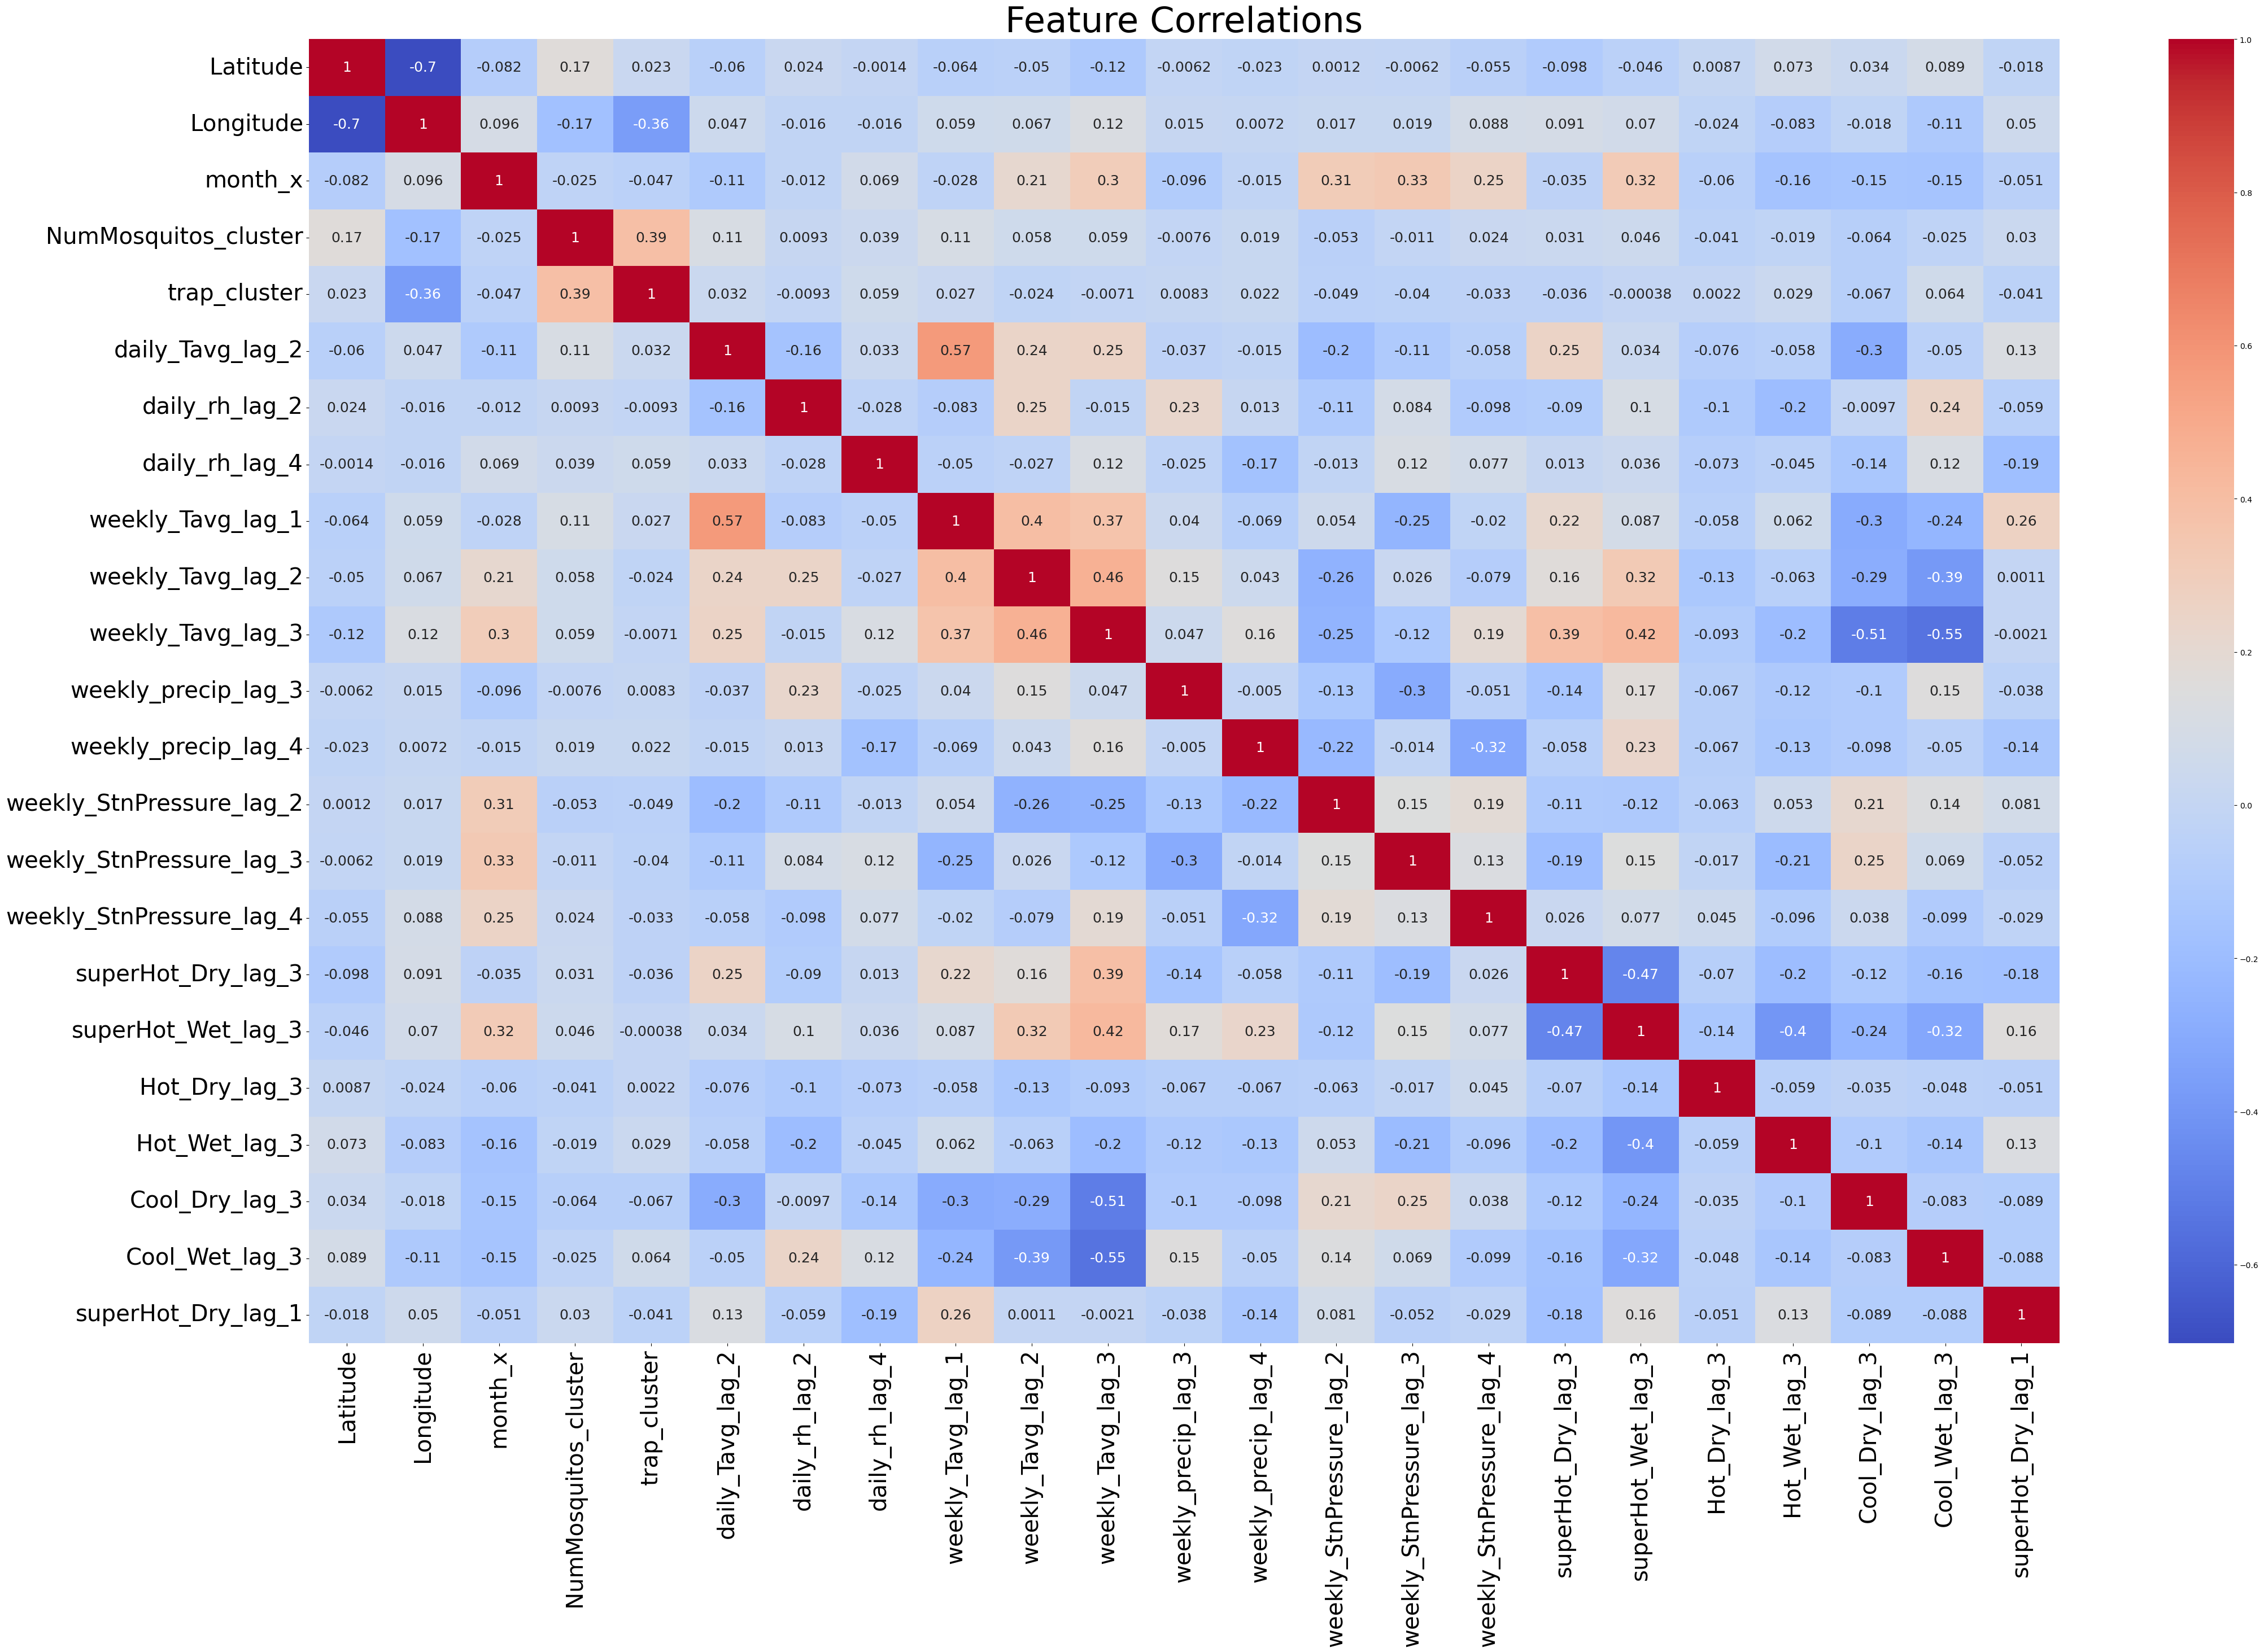

In [15]:
# Visually seeing that there is No multicollinearity among all the selected X features!
plt.figure(figsize=(50,30))
sns.heatmap(selected_X_train.corr(), cmap='coolwarm', annot=True, annot_kws={"fontsize": 18})
plt.tick_params(axis='both', labelsize=29)
plt.title("Feature Correlations", fontsize=45);

# Modeling with Logistic Regression (Best Model)

In [16]:
# Creating Polynomial Features

poly = PolynomialFeatures(include_bias=False, interaction_only=True, degree=2)
poly_X_train = poly.fit_transform(selected_X_train)
poly_X_test = poly.transform(selected_X_test)

In [54]:
# Logistic Regression

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)

# StandardScale input df first
ss = StandardScaler()
train_X_scaled = ss.fit_transform(train_X)    
val_X_scaled = ss.transform(val_X)          
X_test_scaled = ss.transform(selected_X_test)    # use selected_X_test / poly_X_test


# Instantiate Pipeline 
pipe = IMBPipeline([
    ('sampling', SMOTE(k_neighbors=20)),
    ('lr', LogisticRegression())
])


pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(k_neighbors=20)), ('lr', LogisticRegression())],
 'verbose': False,
 'sampling': SMOTE(k_neighbors=20),
 'lr': LogisticRegression(),
 'sampling__k_neighbors': 20,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [55]:
pipe_params = {
               'sampling__sampling_strategy': ['auto'],
               'lr__C': [0.0001,0.000001,0.00000001], 
               'lr__class_weight': [None],
               'lr__max_iter': [1000],
               'lr__solver': ['lbfgs', 'newton-cholesky'],
              }


# If not SMOTE-ing
# pipe_params = {'lr__C': [0.0001,0.000001,0.00000001], 
#                'lr__class_weight': [None],
#                'lr__max_iter': [1000],
#                'lr__solver': ['lbfgs', 'newton-cholesky'],
#               }

In [56]:
grid_lr = GridSearchCV(pipe, pipe_params, n_jobs=-1, scoring='roc_auc', cv=5)
grid_lr.fit(train_X_scaled, train_y)
print(f'Training ROC score: {grid_lr.score(train_X_scaled, train_y)}')
print(f'Validation ROC score: {grid_lr.score(val_X_scaled, val_y)}')
grid_lr.best_params_

Training ROC score: 0.8019926352442325
Validation ROC score: 0.8201908271330677


{'lr__C': 0.0001,
 'lr__class_weight': None,
 'lr__max_iter': 1000,
 'lr__solver': 'newton-cholesky',
 'sampling__sampling_strategy': 'auto'}

In [57]:
grid_lr.best_params_

{'lr__C': 0.0001,
 'lr__class_weight': None,
 'lr__max_iter': 1000,
 'lr__solver': 'newton-cholesky',
 'sampling__sampling_strategy': 'auto'}

In [58]:
feature_coef_ = zip(X_features, grid_lr.best_estimator_['lr'].coef_[0])
feature_coef_df = pd.DataFrame(feature_coef_, columns=['Feature','Coefficient'])
feature_coef_df['Coefficient']  = np.exp(feature_coef_df['Coefficient'])
feature_coef_df.sort_values(by='Coefficient', ascending=False)

# These 23 Leading indicator features are all we need to anticipate and spray preventively, not reactively. 
# NumMosquitos_cluster and trap_cluster are kNN-encoded using historical info and can be trained beforehand with sufficient past data


,Feature,Coefficient
3,NumMosquitos_cluster,1.138446
10,weekly_Tavg_lag_3,1.115025
2,month_x,1.114015
9,weekly_Tavg_lag_2,1.101816
4,trap_cluster,1.096933
15,weekly_StnPressure_lag_4,1.092330
5,daily_Tavg_lag_2,1.084675
8,weekly_Tavg_lag_1,1.059113
14,weekly_StnPressure_lag_3,1.057156
6,daily_rh_lag_2,1.052114


In [59]:
# Adding predicted probabilities and classification predictions to Train set for further analysis

# Extract the prediction probabilities from both train_X and val_X first
train_X_probabilities = grid_lr.best_estimator_['lr'].predict_proba(train_X_scaled)
val_X_probabilities = grid_lr.best_estimator_['lr'].predict_proba(val_X_scaled)
# Get the y_preds for both train_X and val_X
train_X_preds = grid_lr.best_estimator_['lr'].predict(train_X_scaled)
val_X_preds = grid_lr.best_estimator_['lr'].predict(val_X_scaled)


# Concat probabilities and y_preds for train_X set first
train_X_WithProba = pd.concat([train_X.copy().reset_index(), pd.DataFrame(train_X_probabilities, columns=['proba_0', 'proba_1'])], axis=1)
train_X_WithProba = pd.concat([train_X_WithProba, pd.DataFrame(train_X_preds, columns=['y_pred'])], axis=1)
# Adding actual WnvPresent results to train_X to compare with y_preds
train_y_actual = train_y.copy().reset_index()['WnvPresent']
train_X_WithProba = pd.concat([train_X_WithProba, pd.DataFrame(train_y_actual, columns=['WnvPresent'])], axis=1)


# Concat probabilities and y_preds for val_X set 
val_X_WithProba = pd.concat([val_X.copy().reset_index(), pd.DataFrame(val_X_probabilities, columns=['proba_0', 'proba_1'])], axis=1)
val_X_WithProba = pd.concat([val_X_WithProba, pd.DataFrame(val_X_preds, columns=['y_pred'])], axis=1)
# Adding actual WnvPresent results to train_X to compare with y_preds
val_y_actual = val_y.copy().reset_index()['WnvPresent']
val_X_WithProba = pd.concat([val_X_WithProba, pd.DataFrame(val_y_actual, columns=['WnvPresent'])], axis=1)



# Concat both train_X and val_X back into one Training set
trained_preds = pd.concat([train_X_WithProba, val_X_WithProba], axis=0)

In [60]:
trained_preds.to_csv('./datasets/trained_preds.csv', index=False)

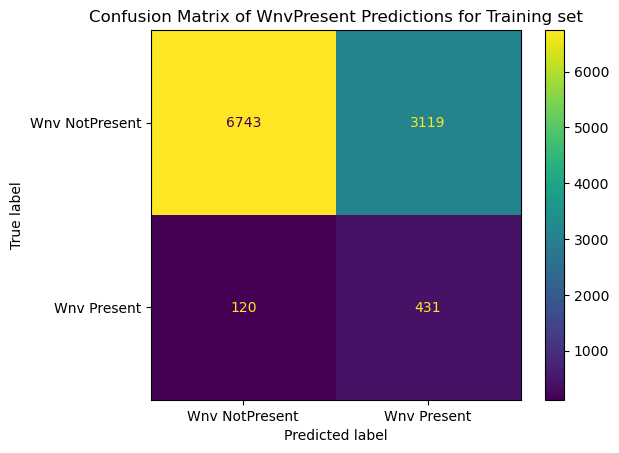

In [61]:
fig, ax = plt.subplots()
cm = confusion_matrix(trained_preds['WnvPresent'], trained_preds['y_pred'])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wnv NotPresent', 'Wnv Present'])
display.plot(ax=ax)
ax.set_title('Confusion Matrix of WnvPresent Predictions for Training set')

plt.show()

In [62]:
print("Accuracy: ", accuracy_score(trained_preds['WnvPresent'], trained_preds['y_pred']))
print("Precision: ", precision_score(trained_preds['WnvPresent'], trained_preds['y_pred']))  # Out of all Traps predicted to be positive, only 12% were correct. The rest of 88% can be seen as insurance costs 
print("Recall/Sensitivity: ", recall_score(trained_preds['WnvPresent'], trained_preds['y_pred']))  # True Positive rate: Among all Traps with WnvPresent, we got 78% of them correct. We can spray at the right places at the right time
print("F1 score: ", f1_score(trained_preds['WnvPresent'], trained_preds['y_pred']))

Accuracy:  0.6889465091712282
Precision:  0.12140845070422535
Recall/Sensitivity:  0.7822141560798548
F1 score:  0.21019263594245305


In [63]:
# Experiment with Changing thresholds for LogReg Classification
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]


threshold_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for threshold in threshold_list:
    preds = get_predictions(trained_preds['proba_1'], threshold)
    recall = recall_score(trained_preds['WnvPresent'], preds)
    print(f'Threshold: {threshold}, Recall: {recall}')

    
# The threshold that produces the best recall rate of 0.97 is 0.4

Threshold: 0.2, Recall: 1.0
Threshold: 0.3, Recall: 1.0
Threshold: 0.4, Recall: 0.9745916515426497
Threshold: 0.5, Recall: 0.7822141560798548
Threshold: 0.6, Recall: 0.32123411978221417
Threshold: 0.7, Recall: 0.014519056261343012
Threshold: 0.8, Recall: 0.0


In [64]:
# Try new thresholds with test set

test_proba = grid_lr.predict_proba(X_test_scaled) 
y_preds_with_threshold = get_predictions(test_proba[:,1], 0.4)

# Conclusion: Changing threshold only widened the overfitting problem. While recall scores improved significantly in the train set,
# the scores dropped significantly in the Kaggle test scores. We will continue to use the default threshold of 50% to classify our preds.

# Modeling with kNearestNeighbor

In [29]:
# kNN

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)

# StandardScale input df first
ss = StandardScaler()
train_X_scaled = ss.fit_transform(train_X)    
val_X_scaled = ss.transform(val_X)          
X_test_scaled = ss.transform(selected_X_test)    # use selected_X_test / poly_X_test


# Instantiate Pipeline 
pipe = IMBPipeline([
    ('sampling', SMOTE()),
    ('knn', KNeighborsClassifier())
])


pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'sampling': SMOTE(),
 'knn': KNeighborsClassifier(),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [30]:
pipe_params = {'sampling__k_neighbors': [5, 20, 50, 80],
               'sampling__sampling_strategy': ['auto'],
               'knn__n_jobs': [-1],
               'knn__n_neighbors': [5, 100, 200, 300],
              }

In [31]:
grid_knn = GridSearchCV(pipe, pipe_params, n_jobs=-1, scoring='roc_auc')
grid_knn.fit(train_X_scaled, train_y)
print(f'Training ROC score: {grid_knn.score(train_X_scaled, train_y)}')
print(f'Validation ROC score: {grid_knn.score(val_X_scaled, val_y)}')
grid_knn.best_params_

Training ROC score: 0.8712570566905481
Validation ROC score: 0.8519914312916534


{'knn__n_jobs': -1,
 'knn__n_neighbors': 100,
 'sampling__k_neighbors': 20,
 'sampling__sampling_strategy': 'auto'}

# Modeling with BaggingClassifier

In [32]:
# BaggingClassifier

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)


# Instantiate Pipeline 
pipe = IMBPipeline([
    ('sampling', SMOTE()),
    ('bc', BaggingClassifier())
])


pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()), ('bc', BaggingClassifier())],
 'verbose': False,
 'sampling': SMOTE(),
 'bc': BaggingClassifier(),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'bc__base_estimator': 'deprecated',
 'bc__bootstrap': True,
 'bc__bootstrap_features': False,
 'bc__estimator': None,
 'bc__max_features': 1.0,
 'bc__max_samples': 1.0,
 'bc__n_estimators': 10,
 'bc__n_jobs': None,
 'bc__oob_score': False,
 'bc__random_state': None,
 'bc__verbose': 0,
 'bc__warm_start': False}

In [33]:
pipe_params = {'sampling__k_neighbors': [5, 20, 50, 80],
               'sampling__sampling_strategy': ['auto'],
               'bc__n_jobs': [-1],
               
              }

In [34]:
grid_bc = GridSearchCV(pipe, pipe_params, n_jobs=-1, scoring='roc_auc')
grid_bc.fit(train_X_scaled, train_y)
print(f'Training ROC score: {grid_bc.score(train_X_scaled, train_y)}')
print(f'Validation ROC score: {grid_bc.score(val_X_scaled, val_y)}')
grid_bc.best_params_

Training ROC score: 0.9758877581887729
Validation ROC score: 0.7539963797501087


{'bc__n_jobs': -1,
 'sampling__k_neighbors': 50,
 'sampling__sampling_strategy': 'auto'}

# Modeling with RandomForestClassifier

In [36]:
# RandomForestClassifier

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)


# Instantiate Pipeline 
pipe = IMBPipeline([
    ('sampling', SMOTE()),
    ('rf', RandomForestClassifier())
])


pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'sampling': SMOTE(),
 'rf': RandomForestClassifier(),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [37]:
pipe_params = {'sampling__k_neighbors': [5, 20, 50, 80],
               'sampling__sampling_strategy': ['auto'],
               'rf__n_jobs': [-1],
               'rf__max_depth': [10],
              }

In [38]:
grid_rf = GridSearchCV(pipe, pipe_params, n_jobs=-1, scoring='roc_auc')
grid_rf.fit(train_X_scaled, train_y)
print(f'Training ROC score: {grid_rf.score(train_X_scaled, train_y)}')
print(f'Validation ROC score: {grid_rf.score(val_X_scaled, val_y)}')
grid_rf.best_params_

Training ROC score: 0.9060504205532209
Validation ROC score: 0.8513640584411768


{'rf__max_depth': 10,
 'rf__n_jobs': -1,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'auto'}

# Modeling with XGBoost

In [41]:
# XGBoost model

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)


# Instantiate Pipeline 
pipe = IMBPipeline([
    ('sampling', SMOTE()),
    ('xgb', XGBClassifier())
])


pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=None, ...))],
 'verbose': False,
 'sampling': SMOTE(),
 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, co

In [42]:
pipe_params = {'sampling__k_neighbors': [5, 20, 50, 80],
               'sampling__sampling_strategy': ['auto'],
               'xgb__n_estimators': [100, 500, 1000],
               'xgb__learning_rate': [0.1, 0.05,0.03],
               'xgb__n_jobs': [-1],
              }

In [43]:
grid_xgb = GridSearchCV(pipe, pipe_params, n_jobs=-1, scoring='roc_auc')
grid_xgb.fit(train_X_scaled, train_y)
print(f'Training ROC score: {grid_xgb.score(train_X_scaled, train_y)}')
print(f'Validation ROC score: {grid_xgb.score(val_X_scaled, val_y)}')
grid_xgb.best_params_

Training ROC score: 0.8964295208325421
Validation ROC score: 0.8540851228886773


{'sampling__k_neighbors': 80,
 'sampling__sampling_strategy': 'auto',
 'xgb__learning_rate': 0.05,
 'xgb__n_estimators': 100,
 'xgb__n_jobs': -1}

# Modeling with AdaBoostClassifier

In [44]:
# AdaBoostClassifier model

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)


# Instantiate Pipeline 
pipe = IMBPipeline([
    ('sampling', SMOTE()),
    ('abc', AdaBoostClassifier())
])


pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()), ('abc', AdaBoostClassifier())],
 'verbose': False,
 'sampling': SMOTE(),
 'abc': AdaBoostClassifier(),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'abc__algorithm': 'SAMME.R',
 'abc__base_estimator': 'deprecated',
 'abc__estimator': None,
 'abc__learning_rate': 1.0,
 'abc__n_estimators': 50,
 'abc__random_state': None}

In [45]:
pipe_params = {'sampling__k_neighbors': [5, 20, 50, 80],
               'sampling__sampling_strategy': ['auto'],
               'abc__learning_rate': [0.01],
               'abc__n_estimators': [50],
              }

In [46]:
grid_abc = GridSearchCV(pipe, pipe_params, n_jobs=-1, scoring='roc_auc')
grid_abc.fit(train_X_scaled, train_y)
print(f'Training ROC score: {grid_abc.score(train_X_scaled, train_y)}')
print(f'Validation ROC score: {grid_abc.score(val_X_scaled, val_y)}')
grid_abc.best_params_

Training ROC score: 0.7628632779710778
Validation ROC score: 0.7731334555755375


{'abc__learning_rate': 0.01,
 'abc__n_estimators': 50,
 'sampling__k_neighbors': 20,
 'sampling__sampling_strategy': 'auto'}

# Modeling with VotingClassifier

In [47]:
# VotingClassifier model

# use selected_X_test / poly_X_test
train_X, val_X, train_y, val_y = train_test_split(selected_X_train, y, test_size=0.25, random_state=0, stratify=y)

# Define three different classifiers
clf1 = LogisticRegression(C=0.0001, solver='lbfgs', max_iter=1000, random_state=42)
# clf2 = AdaBoostClassifier(learning_rate=0.01, n_estimators=50)
clf3 = BaggingClassifier(random_state=42)


# Instantiate Pipeline 
pipe = IMBPipeline([
    ('sampling', SMOTE(k_neighbors=20)),
    ('vc', VotingClassifier(estimators=[('lr', clf1), ('bc', clf3)], voting='soft'))
])


pipe.get_params()


{'memory': None,
 'steps': [('sampling', SMOTE(k_neighbors=20)),
  ('vc',
   VotingClassifier(estimators=[('lr',
                                 LogisticRegression(C=0.0001, max_iter=1000,
                                                    random_state=42)),
                                ('bc', BaggingClassifier(random_state=42))],
                    voting='soft'))],
 'verbose': False,
 'sampling': SMOTE(k_neighbors=20),
 'vc': VotingClassifier(estimators=[('lr',
                               LogisticRegression(C=0.0001, max_iter=1000,
                                                  random_state=42)),
                              ('bc', BaggingClassifier(random_state=42))],
                  voting='soft'),
 'sampling__k_neighbors': 20,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'vc__estimators': [('lr',
   LogisticRegression(C=0.0001, max_iter=1000, random_state=42)),
  ('bc', BaggingClassifier(random_state=42))],
 'v

In [48]:
pipe_params = {}

In [49]:
grid_vc = GridSearchCV(pipe, pipe_params, n_jobs=-1, scoring='roc_auc')
grid_vc.fit(train_X_scaled, train_y)


# Fit the voting classifier on the training data
grid_vc.fit(train_X_scaled, train_y)


print(f'Training ROC score: {grid_vc.score(train_X_scaled, train_y)}')
print(f'Validation ROC score: {grid_vc.score(val_X_scaled, val_y)}')
grid_vc.best_params_


# kaggle score 0.58....even with the best LogReg model params

Training ROC score: 0.9708424945360165
Validation ROC score: 0.8432934283061226


{}

In [52]:
from sklearn.metrics import get_scorer_names, roc_auc_score

print(get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

# Kaggle Submission

In [53]:
# Kaggle Submission

original_test_df = pd.read_csv('./datasets/cleaned_test.csv')

y_preds = grid_lr.predict(X_test_scaled)     # Change fitted_model here will do

# Create csv for Kaggle Submission
submission_csv = pd.DataFrame(columns=['Id', 'WnvPresent'])
submission_csv['Id'] = original_test_df['Id']
submission_csv['WnvPresent'] = y_preds

submission_csv.to_csv('./datasets/kaggle_submission.csv', index=False)